# Configuração inicial


In [ ]:
# Mount drive to colab
from google.colab import drive, files
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importa bibliotecas
import gzip
import pandas as pd
import  numpy as np
import io
import sys
import networkx as nx
from requests import get
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from itertools import zip_longest

MAX = 10 # Define o máximo de cidades nos gráficos TOP X
PATH = '/content/drive/My Drive/Iniciacao Cientifica/'

sys.path.append(f'{PATH}')

import GraphPlot as gp
import ExtraData as ed
from importlib import reload

# Coleta e limpeza

Coleta de dados do vírus Sars-CoV-2, causador da Covid-19.

Os dados utilizados foram retirados do site [brasil.io](https://brasil.io/home/).

In [ ]:
# Download do dataset e decompressão do arquivo gz
covid_file = get('https://data.brasil.io/dataset/covid19/caso_full.csv.gz')
covid_gz = io.BytesIO(covid_file.content)
with gzip.GzipFile(fileobj=covid_gz) as covid_decomp:
    original_df = pd.read_csv(io.TextIOWrapper(covid_decomp, 'utf8')) # open and read csv file

In [ ]:
# pd.set_option("display.max_rows", None, "display.max_columns", None, "display.expand_frame_repr", False) #print everything

In [ ]:
# Seleciona as rows correspondentes a dados do Paraná
parana_df = original_df[original_df['state'].str.contains('PR', case=True)]
parana_df = parana_df[['city', 'date', 'is_last', 'last_available_confirmed',
                       'last_available_deaths', 'new_confirmed' ,'new_deaths']]

# Elimina valores NaN, que indicam a soma dos valores diários
parana_df = parana_df[parana_df['city'].str.contains('NaN', case=True) == False]

# Most recent data dataframe
newest_df = parana_df[parana_df['is_last'].astype(str).str.contains('True')].copy()
newest_df = newest_df.drop('is_last', axis = 1)

# Top 10 cities (most cases/deaths)
max_confirmed_cases = newest_df.nlargest(MAX, 'last_available_confirmed') #df top 10 cities with confirmed cases
df_full_confirmed = gp.top_cases(parana_df, max_confirmed_cases, MAX) #get all data from the top 10 cities with most confirmed cases

max_deaths = newest_df.nlargest(MAX, 'last_available_deaths') #df top 10 cities with deaths
df_full_deaths = gp.top_deaths(parana_df, max_deaths, MAX) #get all data from the top 10 cities with most confirmed cases

In [ ]:
# Adiciona aeroportos ao dataframe
file_airports = open(f'{PATH}/PlanilhaAeroportosPublicos.csv')
df_airports = ed.clean_airports_df(file_airports)
newest_df = ed.add_airports(df_airports, newest_df)

# Dados paranaenses

Adição de macrorregionais ao dataframe

In [ ]:
def fetch_url(url): #get html from the url and extract the data
    url_dict = {}

    #get the url
    url = get(url)
    f = io.BytesIO(url.content)

    #extract data from url
    soup = BeautifulSoup(f, 'lxml')
    for container in soup.select('.content'): #fetch containers with class='container', which are all the important containers
        macrorreg = container.find('strong') #get strong tags inside each container, which are the macrorregional names
        for a_tag in container.find_all('a'): #get a tags, which are the name of the regional and the respective url
            # print(atag['href'])
            # print(atag.string)
            if not a_tag.string.startswith('Macrorregional'):
                url_dict[a_tag.string] = [a_tag['href'], macrorreg.string] #'key' = 'regional name' and 'value' = [link,macrorregional]
    return(url_dict) #return dictionary with key, link and macrorregional

def fetch_cities(url_dict, reg_dict):
    for key in url_dict:
        url = get(url_dict[key][0]) #get the url for each regional in the dictionary
        f = io.BytesIO(url.content)
        soup = BeautifulSoup(f, 'lxml')
    
        for (container1, container2) in zip_longest(soup.select('.layout-column-two'), soup.select('.layout-column-three')):
            for p_tag in container1.find_all('p'):
                if not p_tag.string.startswith('\xa0'):
                    reg_dict[p_tag.string] = (key, url_dict[key][1])
            if container2 is not None:
                for p_tag in container2.find_all('p'):
                    if not p_tag.string.startswith('\xa0'):
                        reg_dict[p_tag.string] = (key, url_dict[key][1])

url = 'http://www.saude.pr.gov.br/Pagina/Regionais-de-Saude'
url_dict = fetch_url(url)
url_dict
reg_dict = {}

# create a dictionary with cities, regionals and macrorregionals
fetch_cities(url_dict, reg_dict)

Graph plotting

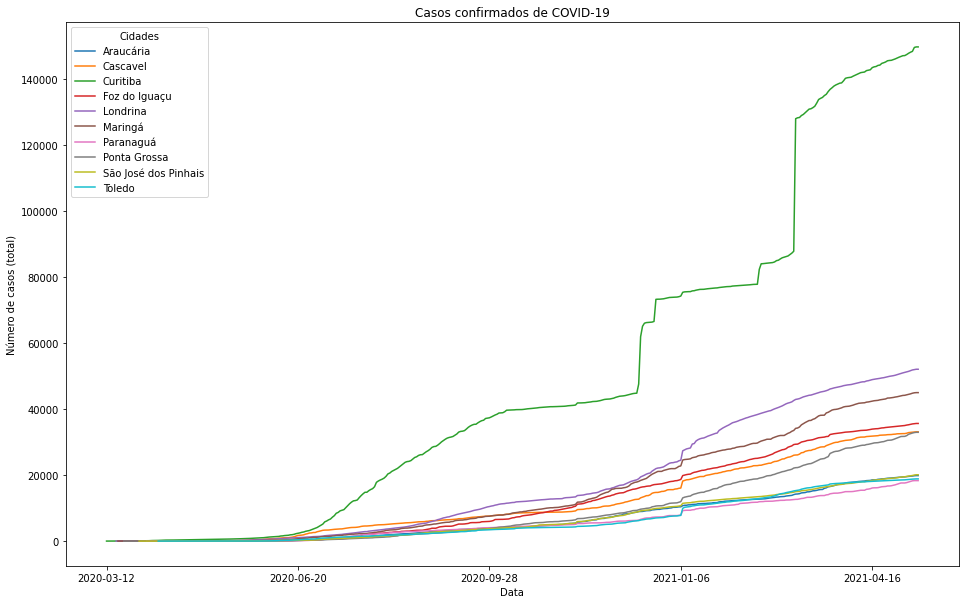

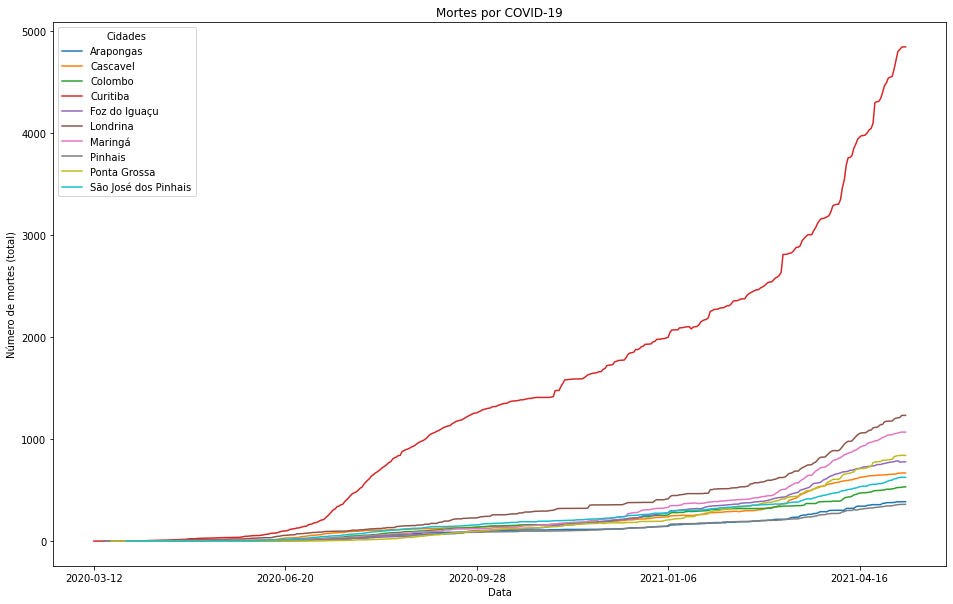

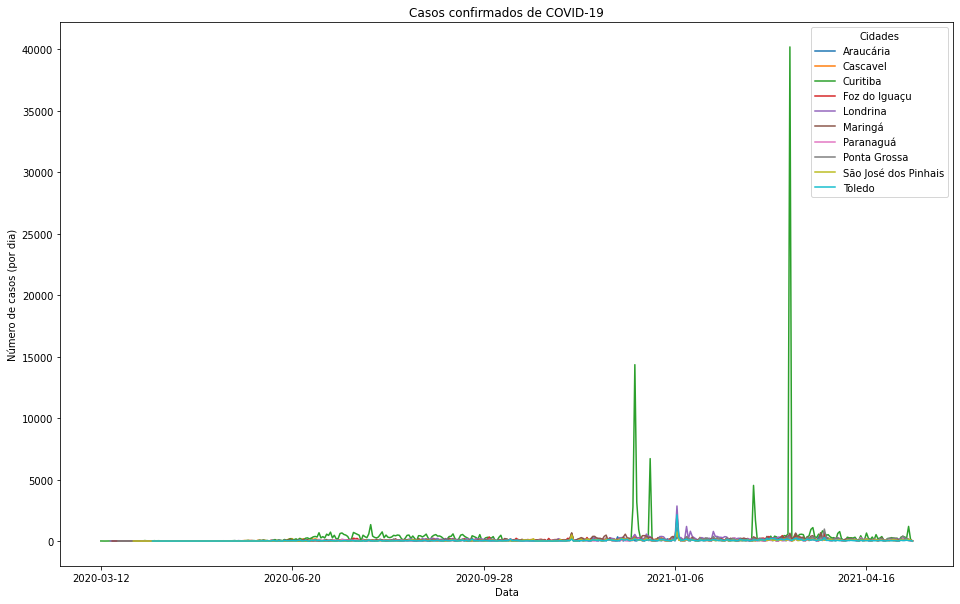

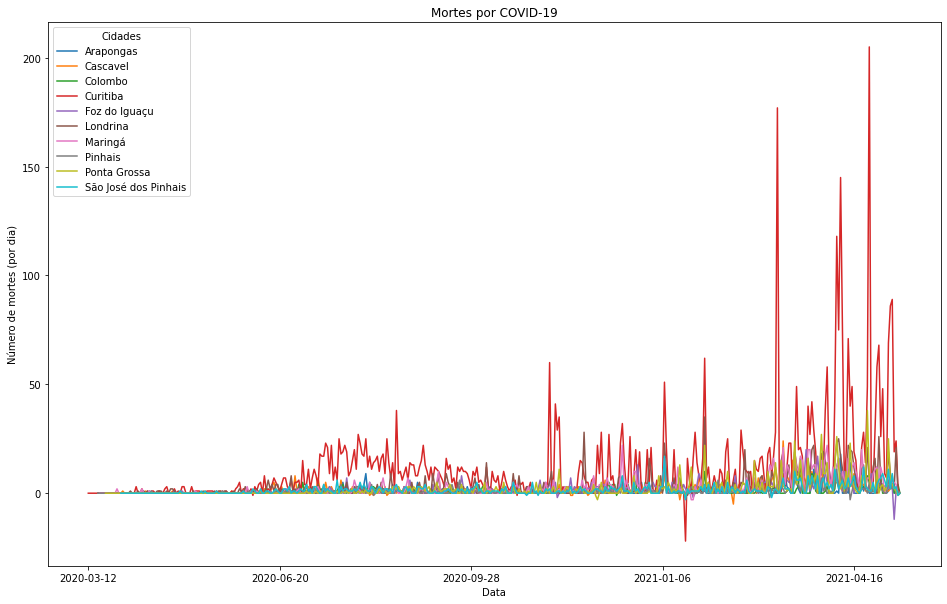

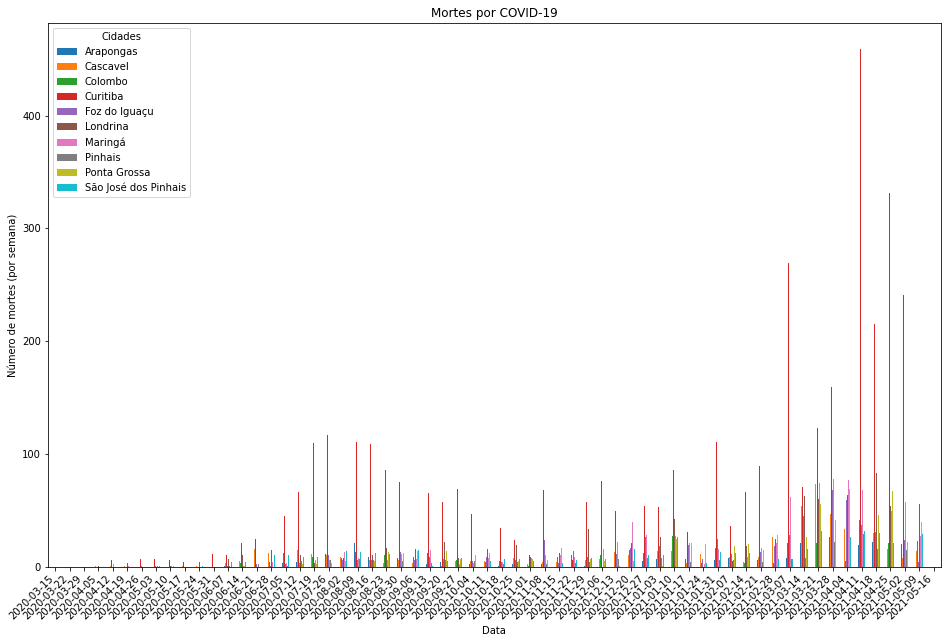

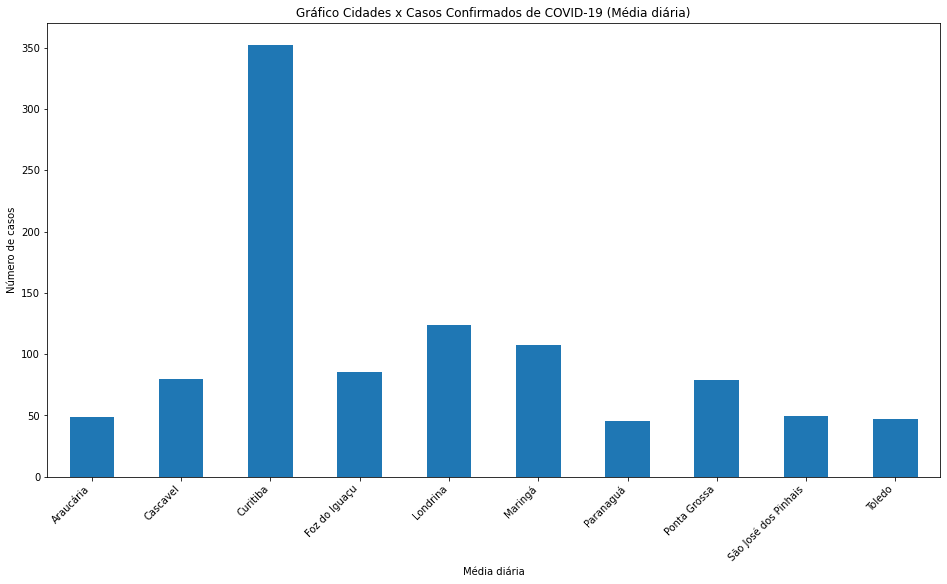

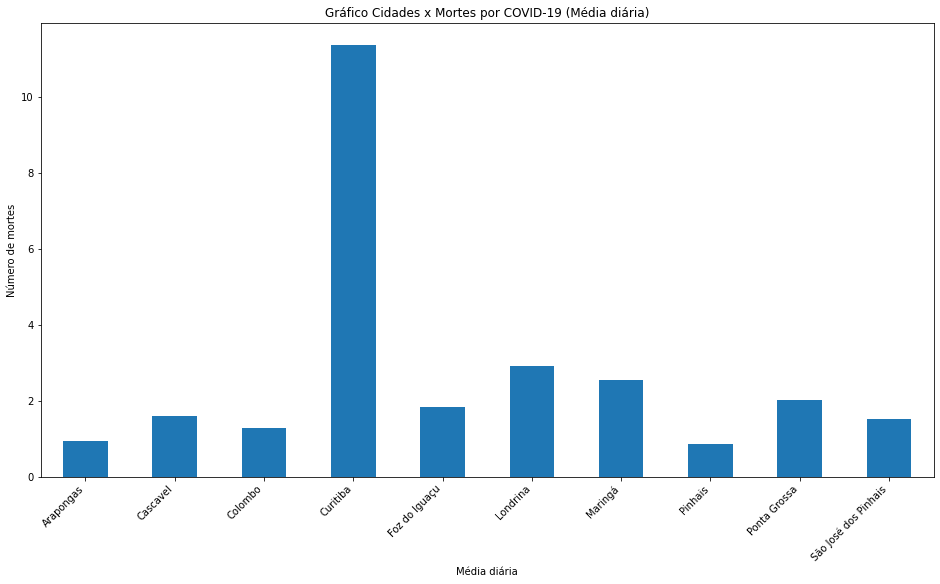

In [ ]:
reload(gp)
#Date x Cases/Deaths (Total)
gp.plot_total_confirmed(df_full_confirmed) #Date x Number of cases (total)
gp.plot_total_deaths(df_full_deaths) #Date x Number of deaths (total)

#Date x Cases/Deaths (per Day)
gp.plot_confirmed_day(df_full_confirmed) #Date x Number of confirmed cases (per day)
gp.plot_deaths_day(df_full_deaths) #Date x Number of deaths (per day)

#Date x Cases/Deaths (per Week)
gp.plot_deaths_week(df_full_deaths)

#Cities x Mean
gp.plot_tm_confirmed(df_full_confirmed, df_confirmed) #calculate mean - confirmed cases/day
gp.plot_tm_deaths(df_full_deaths, df_deaths) #calculate mean - deaths/day

In [ ]:
#create dataframe from the dictionary with macrorregionals, regionals and cities
macrorreg_df = pd.DataFrame.from_dict(reg_dict, orient='index')
macrorreg_df.index.names = ['city']
macrorreg_df.columns = ['regional', 'macrorregional']
macrorreg_df

In [ ]:
#join the newest_df with the macrorregionals dataframe
newest_df = newest_df.merge(macrorreg_df, on='city', how='left')
print(newest_df[newest_df['regional'].isnull()])

                       city        date  last_available_confirmed  last_available_deaths  new_confirmed  new_deaths  airports regional macrorregional
32     Bela Vista da Caroba  2021-05-09                       159                      5              0           0     False      NaN            NaN
95         Diamante D'Oeste  2021-05-09                       379                      8              0           0     False      NaN            NaN
116                 Flórida  2021-05-09                       264                      5              0           0     False      NaN            NaN
128                Guairaçá  2021-05-09                       336                      9              0           0     False      NaN            NaN
130               Guapirama  2021-05-09                       266                      4             29           0     False      NaN            NaN
147  Importados/Indefinidos  2021-05-09                      5752                    146            

Addition of coordinates to dataframe


In [ ]:
coord_url = 'https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/master/csv/municipios.csv'
df_graphs = pd.read_csv(coord_url, error_bad_lines=False)
df_graphs = df_graphs[df_graphs.codigo_uf == 41]
df_graphs = df_graphs.drop(['codigo_ibge', 'capital', 'codigo_uf'], 1)
#juntar df_graphs com newest_df
print(df_graphs)

In [ ]:
# g = nx.Graph()
# g.add_nodes_from(df_graphs['nome'])
# # g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

# nx.draw(g)
# # plt.savefig("simple_path.png")
# plt.show() # display

# Dados brasileiros